# Classification of MNIST using Back-Propagation

### Loading the Dateset

In [12]:
#Loading the data
from mlxtend.data import loadlocal_mnist
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time
from statistics import mean
import math

# Importing the training data
X, y = loadlocal_mnist(images_path='/media/bharath/Storage/UTSPRING2020/MACHINE_LEARNING/Assignment5/MNIST/train-images'
                                   '-idx3-ubyte',
                       labels_path='/media/bharath/Storage/UTSPRING2020/MACHINE_LEARNING/Assignment5/MNIST/train-labels'
                                   '-idx1-ubyte')
# Importing the testing data
X_test, y_test = loadlocal_mnist(images_path='/media/bharath/Storage/UTSPRING2020/MACHINE_LEARNING/Assignment5/MNIST/t10k'
                                             '-images-idx3-ubyte',
                                 labels_path='/media/bharath/Storage/UTSPRING2020/MACHINE_LEARNING/Assignment5/MNIST/t10k'
                                             '-labels-idx1-ubyte')

# Choosing first 10000 training images
# X = X[0:10000, :]
# y = y[0:10000]
# X_test = X_test[0:5000, :]
# y_test = y_test[0:5000]

# Each Column Vector is an image of 784 pixels
X = np.transpose(X)
X_test = np.transpose(X_test)
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(784, 60000)
(60000,)
(784, 10000)
(10000,)


### Network architecture and methods

In [13]:
class SingleLayerNN():
    
    def __init__(self, n_input, n_hidden, n_output):
        self.wij = np.random.rand(n_hidden, n_input)*0.0001
        self.wjk = np.random.rand(n_output, n_hidden)*0.0001
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.lr = 0.0001
        self.trainingLoss = []
        self.batch_num = 0
        self.testingLoss = []
        self.testingAccuracy = []
        
    
    def sigmoid(self, inputs, weights):
        summation = np.dot(weights, inputs) 
        activation = 1/(1+np.exp(-summation))
        return activation
        
    def del_sigmoid(self, inputs, weights):
        return self.sigmoid(inputs, weights) * (1 - self.sigmoid(inputs, weights))
    
    def softmax(self, inputs, weights):
        summation = np.dot(weights, inputs)
        expsum = np.exp(summation)
        dinominator = np.sum(expsum)
        return(expsum/dinominator) # [10 * 1]
    
    def ReLU(self, inputs, weights):
        summation = np.dot(weights, inputs)
        activation = summation * (summation > 0)
        return activation
    
    def del_ReLU(self, inputs, weights):
        summation = np.dot(weights, inputs)
        return 1 * (summation > 0)
    
    def del_softmax(self, inputs, weights):
        return self.softmax(inputs, weights) * (1 - self.softmax(inputs, weights))
    
    def forwardPass(self, image):
        
        self.xi = image # [784 x 1]
        
        if self.activation == 'sigmoid':
            self.xj = self.sigmoid(self.xi, self.wij) 
        if self.activation == 'ReLU':
            self.xj = self.ReLU(self.xi, self.wij) 
            
        self.y_hat = self.softmax(self.xj, self.wjk) 
        
        return self.y_hat
    
    def error_backprop(self, image, label):
        
        y_hat = self.forwardPass(image)
        
        y_d = np.zeros(self.n_output)
        y_d[label] = 1
        
        del_k = y_hat - y_d # [10 *1]
        
        if self.activation == "sigmoid":
            del_j = np.multiply(self.del_sigmoid(image, self.wij), self.wjk.transpose().dot(del_k)) 
        if self.activation == "ReLU":
            del_j = np.multiply(self.del_ReLU(image, self.wij), self.wjk.transpose().dot(del_k))
    
        del_wij = np.outer(del_j, self.xi)
        del_wjk = np.outer(del_k, self.xj)       
        
        # updating step
        self.wij  = self.wij - self.lr*del_wij
        self.wjk  = self.wjk - self.lr*del_wjk
        
        return np.linalg.norm(del_k)
        
    def training(self, train_data, train_labels):
        
        #TODO: epochs and plot training loss
        num_images = train_data.shape[1]
        trLosses = []
        for i in range(num_images):
            TrainingLoss = self.error_backprop(train_data[:, i], train_labels[i])
            trLosses.append(TrainingLoss)
        
        return mean(trLosses)
        
    def testing(self, test_images, test_labels):
        # TODO: epoch testing and plotting loss
        num_images = test_images.shape[1]
        correct = 0
        Losses = []
        for i in range(num_images):
            y_hat = self.forwardPass(test_images[:, i])
            prediction = np.argmax(y_hat)
            y = np.zeros(10)
            y[test_labels[i]] = 1
            Loss = np.linalg.norm(y_hat - y)
            Losses.append(Loss)
            if prediction == test_labels[i]:
                correct += 1
    
        accuracy = (correct/num_images) * 100
        
        return accuracy, mean(Losses)
        
        
    def main(self, batchSize, trainImages, trainLabels, testImages, testLabels, activation = "sigmoid"):
        
        self.activation = activation
        acc = 0
        
       
        while acc <= 97.0 and self.batch_num <= 350:
                
            self.batch_num += 1 
            # Creating a random training batch
            indices = np.random.choice(60000, batchSize)
            train = trainImages[:, indices]
            trLabels = trainLabels[indices]
            
            #Training - get back trianing Loss   
            Loss = self.training(train, trLabels)
            self.trainingLoss.append(Loss)
            
            #Testing - get back testing Loss and Accuracy
            acc, L = self.testing(testImages, testLabels)
            self.testingLoss.append(L)
            self.testingAccuracy.append(acc)
            if acc >= 90:
                self.lr = self.lr * 0.99
            
            #print("Batch Number = " + str(self.batch_num) + " Classification Accuracy = " + str(acc))
            
    
    def postProcess(self, name="default", fignum=0):
        
        # Saving the weights
        self.name = name
        weights = {'layer1':self.wij, 
                   'layer2': self.wjk, 
                   'trainingLoss': self.trainingLoss,
                   'testingLoss': self.testingLoss, 
                   'batches' : self.batch_num,
                   'accuracies' : self.testingAccuracy,
                   'name' : self.name,
                   'acivation': self.activation
                  }
        
        np.save('Weights/'+name+".npy", weights)
        
    
    def setWeights(self, weights):
        
        self.weights = np.load(weights, allow_pickle=True)
        self.wij = self.weights.item().get('layer1')
        self.wjk = self.weights.item().get('layer2')
        self.testingAccuracy = self.weights.item().get('accuracies')
        self.trainingLoss = self.weights.item().get('traingLoss')
        self.testingLoss = self.weights.item().get('testingLoss')
        self.batch_num = self.weights.item().get('batches')
        self.name = self.weights.item().get('name')
        self.activation = self.weights.item().get('activation')

In [14]:
trails = np.arange(50, 750, 100)
trails[0]

50

### Main Implementation of the classification models.
Number of hidden nodes are increased from 50 to 650 in the steps of 100. 
Every network is trained using both sigmoid and ReLU activation seperately. Network weights and performance metrics are saved after evaluation for easier post-processing.

In [55]:
Smodel = [0,0,0,0,0,0,0]
Rmodel = [0,0,0,0,0,0,0]

for i in range(len(trails)):
    n_hidden = trails[i]
    Smodel[i] = SingleLayerNN(784, n_hidden, 10)
    Smodel[i].main(2000, X, y, X_test, y_test, activation = "sigmoid")
    Smodel[i].postProcess("sigmoid_"+str(trails[i]), i)
    
    
    Rmodel[i] = SingleLayerNN(784, n_hidden, 10)
    Rmodel[i].main(2000, X, y, X_test, y_test, activation = "ReLU")
    Rmodel[i].postProcess("ReLU_"+str(trails[i]), i+1)
    print("Trail "+ str(i) + " out of 7 completed")

Trail 0 out of 7 completed
Trail 1 out of 7 completed
Trail 2 out of 7 completed
Trail 3 out of 7 completed
Trail 4 out of 7 completed
Trail 5 out of 7 completed
Trail 6 out of 7 completed


## Post Processing

### Loading the trained weights

In [15]:
trails = np.arange(50, 750, 100)
Smodel = [0,0,0,0,0,0,0]
Rmodel = [0,0,0,0,0,0,0]

for i in range(len(trails)):
    Smodel[i] = SingleLayerNN(784, trails[i], 10)
    Rmodel[i] = SingleLayerNN(784, trails[i], 10)
    
    Smodel[i].setWeights("Weights/sigmoid_"+str(trails[i])+".npy")
    Smodel[i].trainingLoss = np.load("Weights/sigmoid_"+str(trails[i])+".npy", allow_pickle=True).item().get('traingLoss')
    Rmodel[i].setWeights("Weights/ReLU_"+str(trails[i])+".npy")
    Rmodel[i].trainingLoss = np.load("Weights/ReLU_"+str(trails[i])+".npy", allow_pickle=True).item().get('traingLoss')

### Visualizing the performance metrics for a sample architecture with 650 hidden layer nodes.

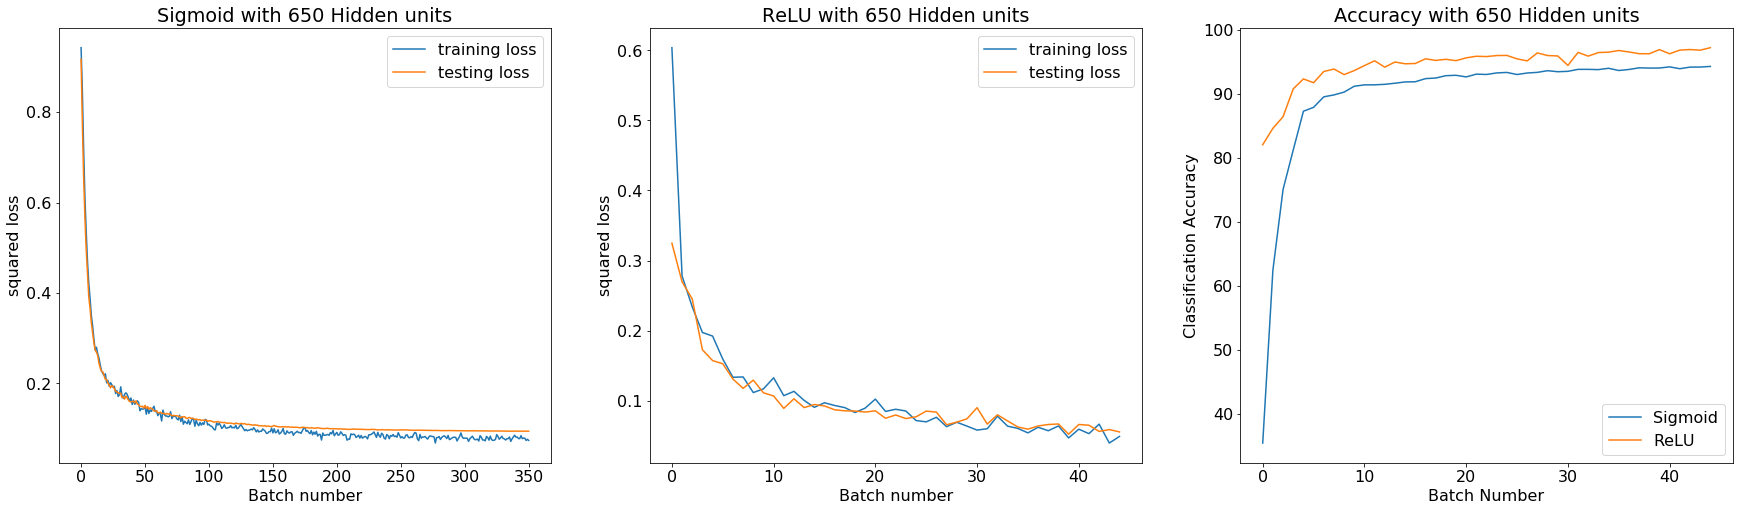

In [16]:
# Plots for 650 Hidden Units
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.plot(range(Smodel[6].batch_num), Smodel[6].trainingLoss, label='training loss')
plt.plot(range(Smodel[6].batch_num), Smodel[6].testingLoss, label='testing loss')
plt.title("Sigmoid with " + str(trails[6]) + " Hidden units")
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("squared loss")


plt.subplot(1,3,2)
plt.plot(range(Rmodel[6].batch_num), Rmodel[6].trainingLoss, label='training loss')
plt.plot(range(Rmodel[6].batch_num), Rmodel[6].testingLoss, label='testing loss')
plt.title("ReLU with " + str(trails[6]) + " Hidden units")
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("squared loss")


plt.subplot(1,3,3)
plt.plot(range(Rmodel[6].batch_num), Smodel[6].testingAccuracy[:Rmodel[6].batch_num], label='Sigmoid')
plt.plot(range(Rmodel[6].batch_num), Rmodel[6].testingAccuracy, label='ReLU')
plt.title("Accuracy with " + str(trails[6]) + " Hidden units")
plt.legend()
plt.xlabel("Batch Number")
plt.ylabel("Classification Accuracy")

plt.savefig("results/case.png")


### Visualizing the performance of all the cases.

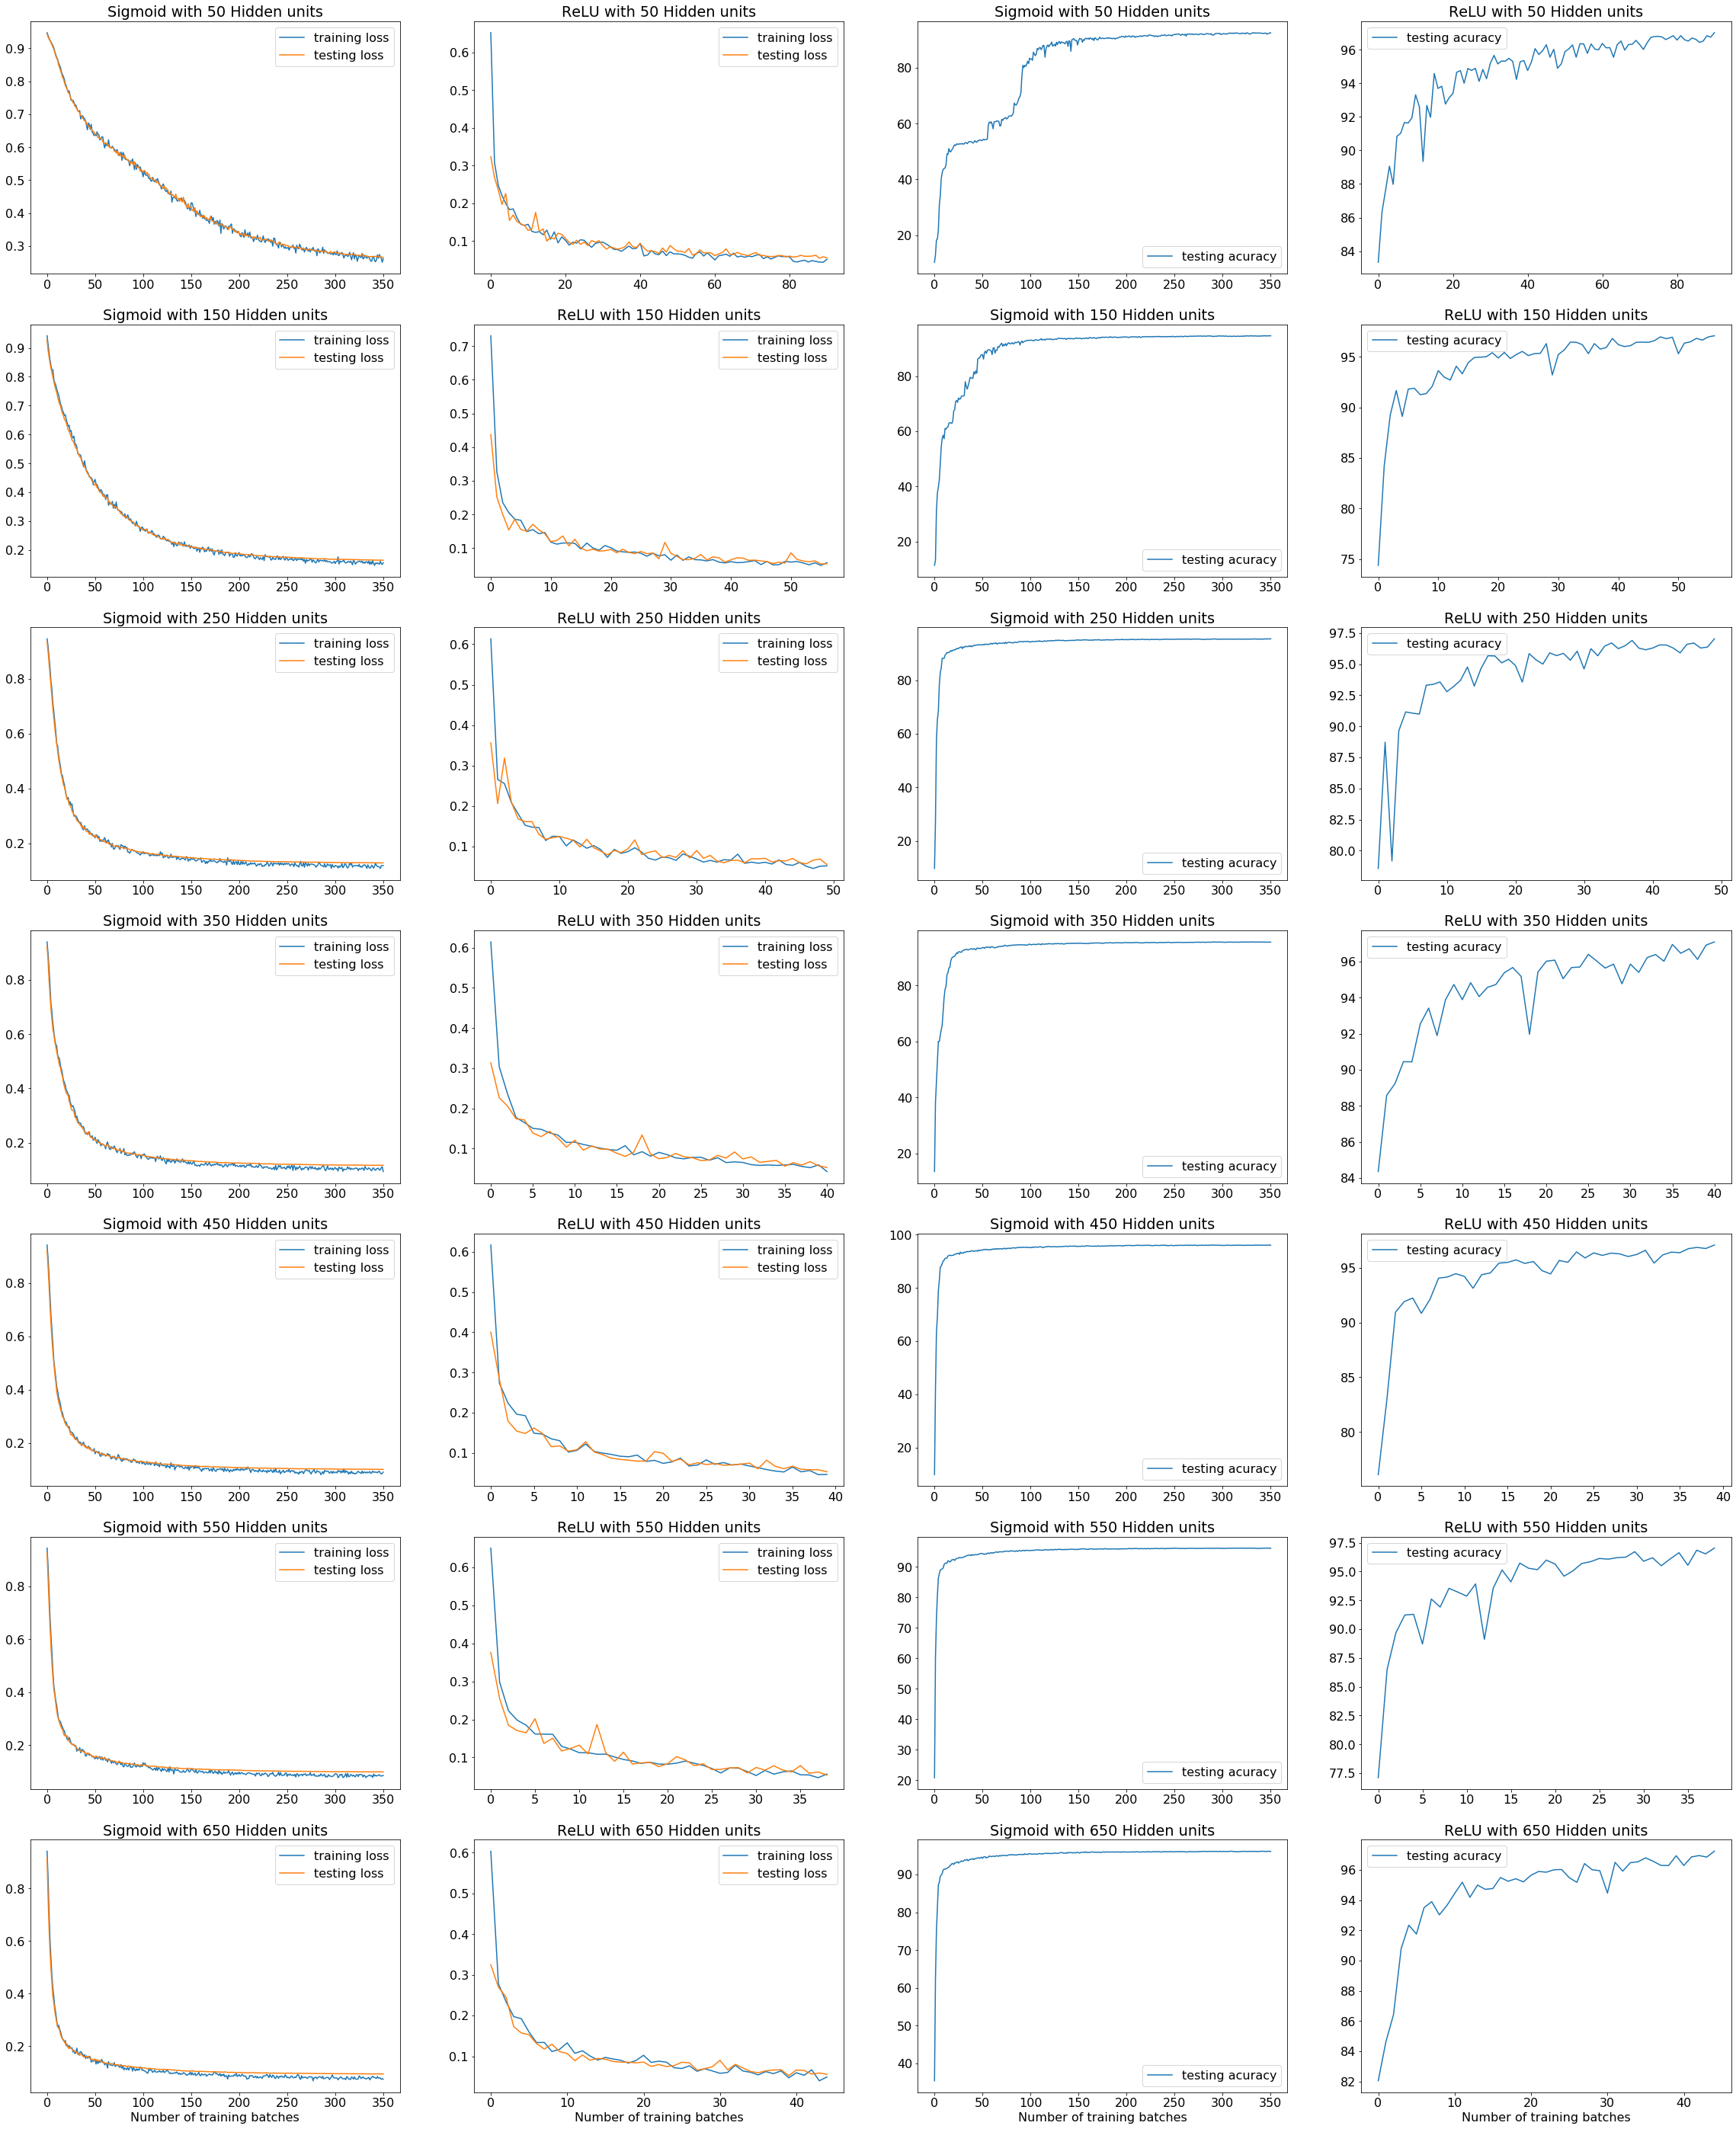

In [114]:
# Plots for Analysis
plt.rcParams.update({'font.size': 16})

counter = 0
plt.figure(figsize=(40,50)) 
for i in range(len(trails)):
    counter += 1
    plt.subplot(7,4, counter)
    plt.plot(range(Smodel[i].batch_num), Smodel[i].trainingLoss, label='training loss')
    plt.plot(range(Smodel[i].batch_num), Smodel[i].testingLoss, label='testing loss')
    plt.title("Sigmoid with " + str(trails[i]) + " Hidden units")
    plt.legend()
    
    if i == 6:
        plt.xlabel("Number of training batches")
    
    counter += 1
    plt.subplot(7,4, counter)
    plt.plot(range(Rmodel[i].batch_num), Rmodel[i].trainingLoss, label='training loss')
    plt.plot(range(Rmodel[i].batch_num), Rmodel[i].testingLoss, label='testing loss')
    plt.title("ReLU with " + str(trails[i]) + " Hidden units")
    plt.legend()
    
    if i == 6:
        plt.xlabel("Number of training batches")
    
    counter += 1
    plt.subplot(7,4, counter)
    plt.plot(range(Smodel[i].batch_num), Smodel[i].testingAccuracy, label='testing acuracy')
    plt.title("Sigmoid with " + str(trails[i]) + " Hidden units")
    plt.legend()
    
    if i == 6:
        plt.xlabel("Number of training batches")
    
    counter += 1
    plt.subplot(7,4, counter)
    plt.plot(range(Rmodel[i].batch_num), Rmodel[i].testingAccuracy, label='testing acuracy')
    plt.title("ReLU with " + str(trails[i]) + " Hidden units")
    plt.legend()
    
    if i == 6:
        plt.xlabel("Number of training batches")
    

plt.savefig("results/Meta.png")



### Variation of accuracy with number of hidden nodes.

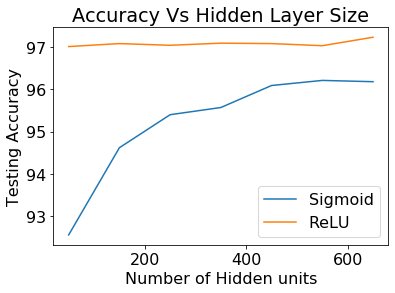

In [115]:
# Final two plots of variation of accuracy with hidden layers

Saccuracies = []
Raccuracies = []
for i in range(len(trails)):
    Saccuracies.append(max(Smodel[i].testingAccuracy))
    Raccuracies.append(max(Rmodel[i].testingAccuracy))
    
plt.figure(100)
plt.plot(trails, Saccuracies, label = "Sigmoid")
plt.plot(trails, Raccuracies, label = "ReLU")
plt.legend()
plt.xlabel("Number of Hidden units")
plt.ylabel("Testing Accuracy")
plt.title("Accuracy Vs Hidden Layer Size")
plt.savefig("results/hiddenlayer_accuracy.png")


In [116]:
# Activation Function Shapes

x = np.linspace(-10,10, 1000)

def sigmoid(x):
    return 1/(1+math.exp(-x))

def ReLU(x):
    return x*(x > 0)

y1 = []
y2 = []

for i in x:
    y1.append(sigmoid(i))
    y2.append(ReLU(i))

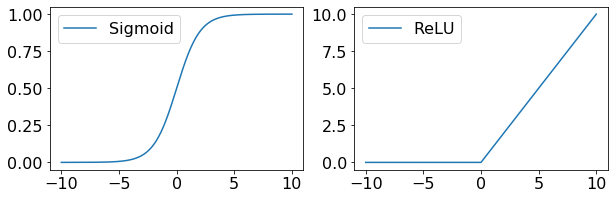

In [117]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(x, y1, label="Sigmoid")
# plt.plot(x, y2, label="ReLU")
plt.legend()
plt.subplot(1,2,2)
# plt.plot(x, y1, label="Sigmoid")
plt.plot(x, y2, label="ReLU")
plt.legend()

plt.savefig("results/activations.png")